# Temporal and spatial analysis

## Table of Contents
* [Loading of the data](#chapter1)
* [Distribution of the movies over the years](#chapter2)
* [Definition of the threshold for successful movies](#chapter3)
* [Temporal analysis](#chapter4)
    * [Evolution of average rating over time](#section_4_1)
    * [Obtaining descriptive features](#section_4_2)
    * [Temporal analysis of genre in successful movies](#section_4_3)
    * [Analysis of box office depending on the release month of the movie](#section_4_4)
    * [Comparison between the evolution of budget over time computed on the overall data and the one computed on successful movies only](#section_4_5)
    * [Comparison between the evolution over time of the genre distribution computed on the overall data and the one computed on successful movies only](#section_4_6)
    * [Comparison between the evolution over time of the language distribution computed on the overall data and the one computed on successful movies only](#section_4_7)
* [Spatial analysis](#chapter5)
    * [Proportion of successful movies per country](#section_5_1)
    * [Distribution of movie releases per country](#section_5_2)

In [1]:
import math

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from collections import defaultdict
from tqdm import tqdm

import matplotlib.pyplot as plt
import shapefile as shp # to plot the world map
import seaborn as sns

import calendar
import os
import ast
import itertools

from collections import Counter

PATH_IN = './datasets/moviedata/'

## 1. Load the reformatted data <a class="anchor" id="chapter1"></a>

In [3]:
fname = os.path.join(PATH_IN, 'final_dataset.csv')
df = pd.read_csv(fname)

df['Languages'] = df['Languages'].apply(lambda x: ast.literal_eval(x))
df['Countries'] = df['Countries'].apply(lambda x: ast.literal_eval(x))
df['Genres'] = df['Genres'].apply(lambda x: ast.literal_eval(x))

df.head(3)

,Wikipedia ID,Freebase ID,Name,Release date,Runtime,Languages,Countries,Genres,IMDb ID,averageRating,...,Budgets,Mpaas,Box offices,Directors,Writers,Producers,Composers,Cinematographers,Editors,Weighted Rating
0,975900,/m/03vyhn,Ghosts of Mars,20010824.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",tt0228333,4.9,...,28000000.0,R,14010832.0,['John Carpenter'],"['Larry Sulkis', 'John Carpenter']",['Sandy King'],"['Anthrax', 'John Carpenter']",['Gary B. Kibbe'],['Paul C. Warschilka'],5.314323
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,20000216.0,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",tt0245916,5.9,...,NaN,NaN,NaN,['Edward Lucas'],"['Michael A. Graham', 'Ted Haimes']",['Michael Shevloff'],['Taylor M. Uhler'],['Shawn Maurer'],['David Post'],6.228941
2,28463795,/m/0crgdbh,Brun bitter,19880000.0,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",tt0094806,5.7,...,NaN,NaN,NaN,['Sølve Skagen'],"['Sølve Skagen', 'Gunnar Staalesen']",['Dag Alveberg'],"['Geir Bøhren', 'Bent Åserud']",['Erling Thurmann-Andersen'],['Malte Wadman'],6.228963


## 2. Distribution of the movies over the years (from milestone 2) <a class="anchor" id="chapter2"></a>

First, we visualize the distribution of movie releases through the years.

In [4]:
df_date = df.copy()

In [5]:
'''Extract the year from the release date'''

# Remove the Nan values
df_date = df_date[pd.isna(df_date['Release date'])==False]

# Extract the year from the release date by converting it to string
df_date['Release date'] = df_date['Release date'].apply(lambda x: str(x))
df_date['Release year'] = df_date['Release date'].str[:4]

# Convert string to int
df_date['Release date'] = df_date['Release year'].astype(int)

In [6]:
'''Compute the range of the values'''
print(f"The oldest movie from the dataset was released in {df_date['Release year'].min()}.")
print(f"The more recent movie from the dataset was released in {df_date['Release year'].max()}.")

The oldest movie from the dataset was released in 1888.
The more recent movie from the dataset was released in 2016.


In [7]:
groupby_year = df_date.groupby('Release year').count()

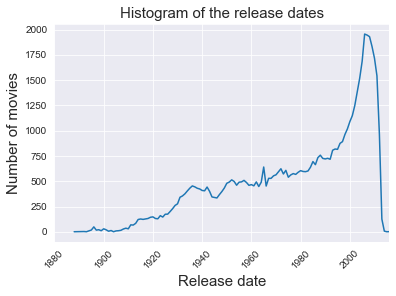

In [8]:
'''Plot the histogram'''
hist = plt.plot(groupby_year['Wikipedia ID'].index.astype(int), groupby_year['Wikipedia ID'])
plt.xlabel("Release date", fontsize=15)
plt.ylabel("Number of movies", fontsize=15)
plt.xlim(1880, 2016)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.title('Histogram of the release dates', fontsize=15)
plt.show()

From the histogram, we can observe that a large part of our dataset contains movies released after 1990. This drastic increase in the amount of movies produced in the past 40 years is most likely caused by the technological advancements, which enabled the movie industry to become ubiquitous. Due to this, we expect the result from this period to be a better representation of the real world, when conducting the temporal analysis.

## 3. Define the threshold for successful movies <a class="anchor" id="chapter3"></a>

As explained previously, we use a weighted rating as the measurement of success for the movies. We compute the threshold for the weighted rating above which we consider a movie to be successful.

In [50]:
threshold = df['Weighted Rating'].quantile(q=0.95)
print(f'In the dataset, 5% of the movies have a weighted rating above {threshold:.3}.')

In the dataset, 5% of the movies have a weighted rating above 6.61.


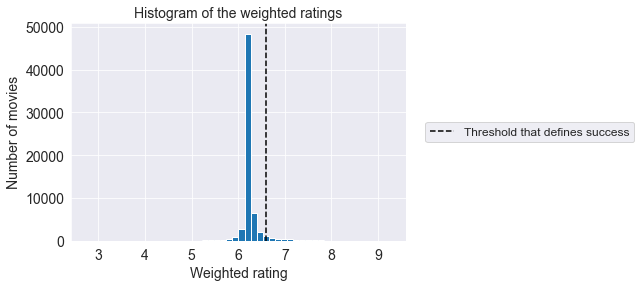

In [10]:
plt.figure()
plt.hist(df['Weighted Rating'], bins=50)
plt.axvline(threshold, color='k', linestyle='--', label='Threshold that defines success')

plt.xticks(fontsize=14)
plt.xlabel("Weighted rating", fontsize=14)

plt.yticks(fontsize=14)
plt.ylabel("Number of movies", fontsize=14)

plt.title("Histogram of the weighted ratings", fontsize=14)
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=12)
plt.show()
# plt.savefig('histogram_weighted_rating.png', bbox_inches='tight')

From this weighted rating, we define successful movies as the ones that have a value over 6,61. This results in the 5% of movies with highest weighted rating, which corresponds to 3290 movies.

## 4. Temporal analysis <a class="anchor" id="chapter4"></a>

In [11]:
# Extract the decade from the release date (round to the lower decade)
def extract_decade(date):
    date = str(date)[:3] + '0'
    return int(date)

def extract_month(date):
    return int(str(date)[4:6])

In [12]:
def create_reduced_df(list_var_name, discretization='none'):
    '''New reduced dataset containing only the variables of interest + the release decade (or month) of the movies'''
    
    df_reduced = df[list_var_name].copy()
    
    # Remove the nan values
    for var_name in list_var_name:
        if var_name in ['Languages', 'Countries', 'Genres']:
            df_reduced = df_reduced[df_reduced[var_name].isin([[]]) == False]
        else:
            df_reduced = df_reduced[pd.isna(df_reduced[var_name]) == False]
    
    # Extract the release decade (or month)
    if discretization == 'decade':
        df_reduced['Release decade'] = df_reduced['Release date'].apply(extract_decade)
    elif discretization == 'month':
        df_reduced['Release month'] = df_reduced['Release date'].apply(extract_month)
        df_reduced = df_reduced[df_reduced['Release month'] != 0] # remove rows where the release date misses the month
    
    return df_reduced

### a) Evolution of average rating over time <a class="anchor" id="section_4_1"></a>

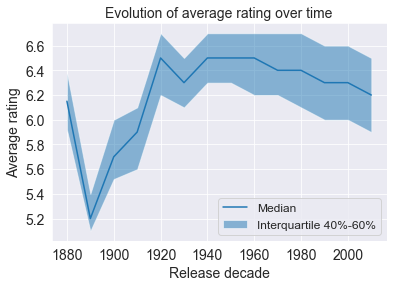

In [13]:
df_reduced = create_reduced_df(['Release date', 'averageRating'], discretization='decade')
    
# Compute the median per decade
median_per_decade = df_reduced.groupby('Release decade')['averageRating'].median()
Q1_per_decade = df_reduced.groupby('Release decade')['averageRating'].quantile(q=0.4)
Q3_per_decade = df_reduced.groupby('Release decade')['averageRating'].quantile(q=0.6)
    
# Plot the figure
plt.figure()
plt.plot(median_per_decade, label='Median')
plt.fill_between(
    median_per_decade.index,
    Q1_per_decade.values,
    Q3_per_decade.values,
    alpha=0.5,
    label='Interquartile 40%-60%'
)
    
plt.xticks(fontsize=14)
plt.xlabel('Release decade', fontsize=14)

plt.yticks(fontsize=14)
plt.ylabel('Average rating', fontsize=14)

plt.title('Evolution of average rating over time', fontsize=14)
plt.legend(fontsize=12)
plt.show()
# plt.savefig('best_weightedRating_' + var_name + '_median_over_time.png')

The average rating has decreased in the recent years. This can be due to people becoming more critical as the amount of released movies is increasing, so there are more movies to compare to. Or only the most famous and appreciated movies are referenced for the first decades, while now we have statistics about almost every existing movies.

### b) Obtaining descriptive features <a class="anchor" id="section_4_2"></a>

In [14]:
"""
    Eliminate empty values from the selected features.
    In order to do so, empty values are replaced by None,
    which is then effeciently removed.
"""

features_to_encode = ['Languages', 'Countries', 'Genres']
encoding_map = defaultdict()
encoded_df = df.copy()

for feature in features_to_encode:
    encoding_map[feature] = set()
    encoded_df[feature] = encoded_df[feature].apply(lambda x : None if len(x) == 0 else x)
    encoded_df = encoded_df[encoded_df[feature].notna()]
    encoded_df[feature].apply(lambda x : encoding_map[feature].update(x))

for feature in features_to_encode:
    encoding_map[feature] = list(encoding_map[feature])

print(encoded_df.shape[0], df.shape[0])

54884 65791


In [15]:
"""
    Preprocess a common genre, which is a combination of 2 other.
"""
encoded_df = df.copy()

def replace_values_in_list(df, col, old_values, new_value):
    df[col] = df[col].apply(lambda x: [new_value if check_common_elements(x, old_values) else i for i in x])
    return df

# function that checks if two lists have elements in common
def check_common_elements(list1, list2):
    return bool(set(list1) & set(list2))

encoded_df = replace_values_in_list(encoded_df, 'Genres', 'Action/Adventure', ['Action', 'Adventure'])
encoded_df['Genres'] = encoded_df['Genres'].apply(lambda x : list(set(x)))

In [16]:
"""
    Adjust the Data format for the features below, in order to be able to create columns
    out of the lists of categories.
"""
small_features = ['Languages', 'Genres', 'Countries']
feature_map = defaultdict()

chars_to_remove = set(['\'', '[', ']', ' ', '\"'])

for feature in tqdm(small_features):
    feature_map[feature] = set()
    encoded_df[feature] = encoded_df[feature].apply(lambda x : ''.join([c for c in str(x) if c not in chars_to_remove]))
    new_columns = encoded_df[feature].str.get_dummies(',').astype(bool)
    feature_map[feature].update(new_columns.columns)
    new_columns = new_columns.drop(new_columns.columns[new_columns.apply(lambda col: col.sum() < 100)], axis=1)
    encoded_df = pd.concat([encoded_df, new_columns], axis = 1)

100%|██████████| 3/3 [00:31<00:00, 10.61s/it]


In [17]:
"""
    Adjust the Director data, in order to be usefull for the Feature selection.
    Threshold is chosen, otherwise, due to the big amount of Directors,
    the encoding is very costly.
"""
directors = defaultdict(int)
def add_to_map(current_map, word_list):
    for word in word_list:
        directors[word] += 1

encoded_df['Directors'] = encoded_df['Directors'].apply(lambda x : ''.join([c for c in str(x) if c not in chars_to_remove]))
encoded_df["Directors"].apply(lambda x :  add_to_map(directors, x.split(',')))
for director, value in tqdm(directors.items()):
    if value >= 15:
        new_column = encoded_df['Directors'].apply(lambda x : director in x.split(','))
        new_column = new_column.rename(director)
        encoded_df = pd.concat([encoded_df, new_column], axis=1)

100%|██████████| 24337/24337 [02:51<00:00, 141.94it/s] 


In [18]:
"""
    Obtain feature importance by utilizing a Random Forest
"""

#Drop columns, which are unnecessary
importance_df = encoded_df.drop(columns=['Wikipedia ID', 'Freebase ID', 'Name', 'Languages', 'Countries', 'Genres', 'IMDb ID', 'Release date', 'averageRating', 'numVotes',"Mpaas", 'Box offices',
                               "Directors", "Writers", "Producers", "Composers", "Cinematographers", "Editors"])
importance_df = importance_df.dropna()
wr = importance_df["Weighted Rating"]

importance_df = importance_df.drop(columns = ['Weighted Rating'])
X_train, X_test, y_train, y_test = train_test_split(importance_df, wr, random_state=42)


#Fit the Random Forest Regressor
feature_names = [f"{importance_df.columns[i]}" for i in range(importance_df.shape[1])]
forest = RandomForestRegressor(random_state=0)
forest.fit(X_train, y_train)

#Obtain imprortance
importances = forest.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending = False)[:20]

Runtime                  0.194719
Budgets                  0.132902
Drama                    0.024273
English                  0.021871
Animation                0.013690
CrimeFiction             0.013268
UnitedStatesofAmerica    0.011262
ScienceFiction           0.010479
Horror                   0.010459
Thriller                 0.010340
Adventure                0.010129
Comedy                   0.009492
Mystery                  0.009324
Action                   0.008930
RomanceFilm              0.008720
Action/Adventure         0.008300
Cult                     0.008058
Superheromovie           0.008005
UnitedKingdom            0.007655
Psychologicalthriller    0.007376
dtype: float64

In [19]:
"""
    Get the most descriptive categories of a feature,
    as outputed by the Random Forest.
"""
def get_most_descriptive_values_in_category(feature, n):
    count = 0
    most_descriptive = []
    for index, value in forest_importances.sort_values(ascending = False).iteritems():
        if index.replace(" ", "") in feature_map[feature]:
            count += 1
            most_descriptive.append(index)
            if count == n:
                break
    return most_descriptive

In [20]:
"""
    Combine the categorical values into one
"""
importance_sum = defaultdict(float)
enc = ['Languages', 'Countries', 'Genres', 'Directors']
feature_map['Directors'] = set()
feature_map['Directors'].update(directors.keys())

for index, value in forest_importances.iteritems():
    for feature in enc:
        if index.replace(" ", "") in feature_map[feature]:
            importance_sum[feature] += value

/var/folders/22/z208ks5x5vv4dfqj0fjxt9l00000gn/T/ipykernel_78246/2441426546.py:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in forest_importances.iteritems():


In [21]:
importance_sum['Budgets'] = forest_importances['Budgets']
importance_sum['Runtime'] = forest_importances['Runtime']
importance_sum

defaultdict(float,
            {'Languages': 0.03340494975217566,
             'Genres': 0.4428200916423572,
             'Countries': 0.055682116960037706,
             'Directors': 0.14234689161347922,
             'Budgets': 0.13290166286412725,
             'Runtime': 0.19471908522288292})

In [22]:
# Therefore top Genres are Drama, Animation, Crime Fiction, Mystery, Romance , Science Fiction, Comedy, Adventure, Thriller, Action
most_descriptive_genres = ['Drama', 'Animation', 'CrimeFiction', 'Mystery', 'RomanceFilm', 'ScienceFiction', 'Comedy', 'Adventure', 'Thriller', 'Action']
most_descriptive_countries = ['UnitedStatesofAmerica', 'UnitedKingdom']
lr_columns = most_descriptive_genres
lr_columns.extend(most_descriptive_countries)
lr_columns.append('Budgets')
lr_columns.append('Runtime')
lr_columns.append('Weighted Rating')
lr_df = encoded_df[lr_columns]

lr_df = lr_df.dropna()
lr_df['Budgets'] = (lr_df['Budgets'] - lr_df['Budgets'].mean()) / lr_df['Budgets'].std()
lr_df['Runtime'] = (lr_df['Runtime'] - lr_df['Runtime'].mean()) / lr_df['Runtime'].std()

### c) Temporal analysis of genre in successful movies <a class="anchor" id="section_4_3"></a>

For the most descriptive genres determined during the feature extraction part of our analysis, we want to analyze how their contribution to the success of movies evolve over the years. With this in mind, we calculate the proportion of successful movies over time, for each of these genres. More precisely, for every decade, we compute the number of successful movies divided by the total number of movies for a certain genre.

In [23]:
most_descriptive_genres = ['Drama', 'Animation', 'CrimeFiction', 'Mystery', 'RomanceFilm', 'ScienceFiction', 'Comedy', 'Adventure', 'Thriller', 'Action']

In [24]:
df_reduced = create_reduced_df(['Genres', 'Release date', 'Weighted Rating'], discretization='decade')

In [25]:
def categorical_var_preprocessing(arg_df, list_categorical_var):
    '''For variables that contain list of values, create a dataframe with one row per value'''
    
    df_out = arg_df.copy()
    
    # Eg. for movies that have several genres, create several rows that each contains a genre, and the release decade of the movie
    list_nonCategorical_var = [elem for elem in arg_df.columns if elem not in list_categorical_var]
    def cartesian_product(x):
        if len(list_categorical_var) == 1: # one categorical variable
            var_name = list_categorical_var[0]
            if len(x[var_name])>1:
                return [[v1,v2]+[x[var] for var in list_nonCategorical_var[1:]] for v1,v2 in itertools.product(x[var_name], [x[list_nonCategorical_var[0]]])]
            else:
                return [x[var_name] + [x[var] for var in list_nonCategorical_var]]
                        
    df_out = df_out.apply(cartesian_product, axis=1)
    
    # Flatten the list
    list_flatten = list(itertools.chain.from_iterable(df_out))
    df_out = pd.DataFrame(list_flatten, columns=list_categorical_var+list_nonCategorical_var)
    
    return df_out

In [26]:
df_reduced = categorical_var_preprocessing(df_reduced, ['Genres'])
df_reduced

,Genres,Release date,Weighted Rating,Release decade
0,Thriller,20010824.0,5.314323,2000
1,Science Fiction,20010824.0,5.314323,2000
2,Horror,20010824.0,5.314323,2000
3,Adventure,20010824.0,5.314323,2000
4,Supernatural,20010824.0,5.314323,2000
...,...,...,...,...
204974,Comedy,19720922.0,6.228080,1970
204975,Thriller,20020000.0,6.105180,2000
204976,Horror,20020000.0,6.105180,2000
204977,Slasher,20020000.0,6.105180,2000


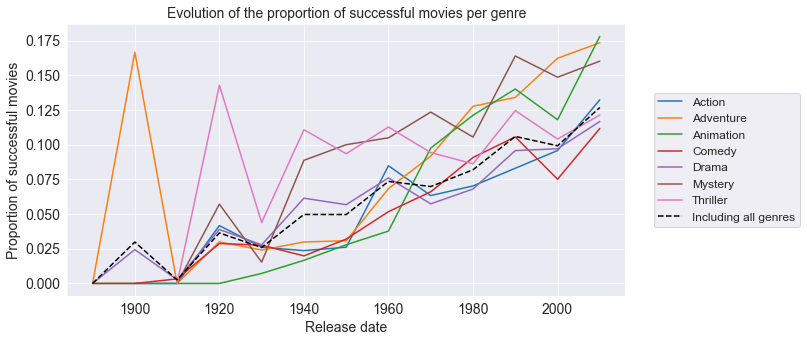

In [27]:
# Keep only the most descriptive genres
df_reduced = df_reduced[df_reduced['Genres'].isin(most_descriptive_genres)]

# Group by genre
df_groupby_genre = df_reduced.groupby('Genres')

# Plot the figure
plt.figure(figsize=(10,5))
for group_name, df_group in df_groupby_genre:
    df_groupby_decade = df_group.groupby('Release decade')
    date = []
    proportion = []
    for subgroup_name, df_subgroup in df_groupby_decade:
        ratio_success = len(df_subgroup[df_subgroup['Weighted Rating']>threshold]) / len(df_subgroup)
        date.append(subgroup_name)
        proportion.append(ratio_success)
    plt.plot(date, proportion, label=group_name)
        
df_groupby_decade = df_reduced.groupby('Release decade') # statistics computed on all movies (including all genres)
date = []
proportion = []
for group_name, df_group in df_groupby_decade:
    ratio_success = len(df_group[df_group['Weighted Rating']>threshold]) / len(df_group)
    date.append(group_name)
    proportion.append(ratio_success)
plt.plot(date, proportion, label='Including all genres', color='k', linestyle='--')

plt.xticks(fontsize=14)
plt.xlabel('Release date', fontsize=14)

plt.yticks(fontsize=14)
plt.ylabel('Proportion of successful movies', fontsize=14)

plt.title('Evolution of the proportion of successful movies per genre', fontsize=14)
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=12)
plt.show()
# plt.savefig('proportion_successful_movies_per_genre.png', bbox_inches='tight')

We can see that for each of these most descriptive genres, except Comedy and Action, the proportion of successful movies is above the general proportion, which is computed including all the genres. In particular, Adventure, Animation and Mystery are among the successful genres nowadays.

### d) Analysis of box office depending on the release month of the movie <a class="anchor" id="section_4_4"></a>

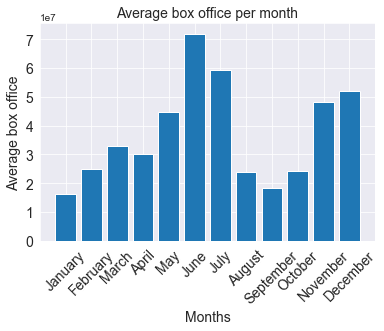

In [28]:
df_reduced = create_reduced_df(['Release date', 'Box offices'], discretization='month')
average_monthly_boxoffice = df_reduced.groupby('Release month')['Box offices'].mean()


plt.figure()
plt.bar(calendar.month_name[1:], average_monthly_boxoffice)

plt.xticks(fontsize=14, rotation=45)
plt.xlabel('Months', fontsize=14)

plt.yticks(fontsize=14)
plt.ylabel('Average box office', fontsize=14)

plt.title('Average box office per month', fontsize=14)
plt.show()
# plt.savefig('boxoffice_per_month.png', bbox_inches='tight')

On average, the box office is the highest for movies released in June and July. It can be due to people going to cinema more often during the summer holidays.

### e) Comparison between the evolution of budget over time computed on the overall data and the one computed on successful movies only <a class="anchor" id="section_4_5"></a>

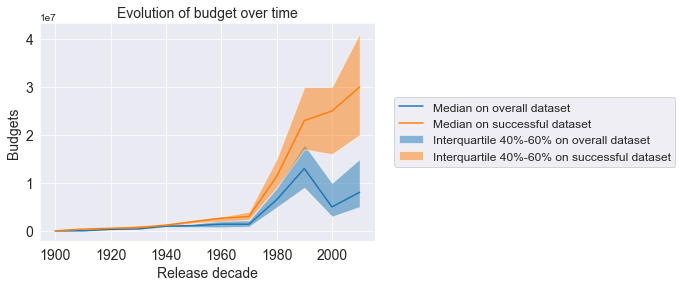

In [29]:
# Statistics for the dataframe containing the whole data
df_overall = create_reduced_df(['Release date', 'Budgets', 'Weighted Rating'], discretization='decade')
overall_median = df_overall.groupby('Release decade')['Budgets'].median()
overall_Q1 = df_overall.groupby('Release decade')['Budgets'].quantile(q=0.4)
overall_Q3 = df_overall.groupby('Release decade')['Budgets'].quantile(q=0.6)

# Statistics for the dataframe containing only the successful movies
df_successful = create_reduced_df(['Release date', 'Budgets', 'Weighted Rating'], discretization='decade')
df_successful = df_successful[df_successful['Weighted Rating']>threshold]
successful_median = df_successful.groupby('Release decade')['Budgets'].median()
successful_Q1 = df_successful.groupby('Release decade')['Budgets'].quantile(q=0.4)
successful_Q3 = df_successful.groupby('Release decade')['Budgets'].quantile(q=0.6)

# Plot the figure
plt.figure()
plt.plot(overall_median, label='Median on overall dataset')
plt.fill_between(
    overall_median.index,
    overall_Q1.values,
    overall_Q3.values,
    alpha=0.5,
    label='Interquartile 40%-60% on overall dataset'
)
plt.plot(successful_median, label='Median on successful dataset')
plt.fill_between(
    successful_median.index,
    successful_Q1.values,
    successful_Q3.values,
    alpha=0.5,
    label='Interquartile 40%-60% on successful dataset'
)

plt.xticks(fontsize=14)
plt.xlabel('Release decade', fontsize=14)

plt.yticks(fontsize=14)
plt.ylabel('Budgets', fontsize=14)

plt.title('Evolution of budget over time', fontsize=14)
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=12)
plt.show()
# plt.savefig('best_weightedRating_' + var_name + '_median_over_time.png', bbox_inches='tight')

Mean and standard deviation being usually not robust to outliers/extreme values, we decided to use the median, with the interquartile range between 40% and 60% as the error bar. From the comparison between the overall dataset and the one containing only successful movies, we can observe that a higher budget might lead to a successful movie.

### f) Comparison between the evolution over time of the genre distribution computed on the overall data and the one computed on successful movies only <a class="anchor" id="section_4_6"></a>

In [30]:
def plot_proportion(var_name, successful=False):
    
    '''1. Preprocess the data'''
    if successful:
        df_reduced = create_reduced_df(['Release date', var_name, 'Weighted Rating'], discretization='decade')
        df_reduced = df_reduced[df_reduced['Weighted Rating']>threshold]
    else:
        df_reduced = create_reduced_df(['Release date', var_name], discretization='decade')
    
    # Eg. for movies that have several genres, create several rows that each contains a genre, and the release decade of the movie
    df_reduced = categorical_var_preprocessing(df_reduced, [var_name])
    
    
    '''2. Compute statistics'''
    # Compute the time range (x-axis of the plot)
    decade_min = df_reduced['Release decade'].min()
    decade_max = df_reduced['Release decade'].max()
    decade_range = np.arange(decade_min, decade_max+10, 10)

    # Compute the number of movies per decade (to compute proportions)
    count_movies_per_decade = df_reduced.groupby('Release decade').count()
    
    # 10 most frequent values
    if var_name == 'Genres':
        # frequent_values = ['Drama', 'Comedy', 'Romance Film', 'Black-and-white', 'Action', 'Thriller', 'Short Film', 'World cinema', 'Crime Fiction', 'Indie']
        frequent_values = ['Drama', 'Comedy', 'Romance Film', 'Thriller', 'Action', 'Black-and-white', 'World cinema', 'Crime Fiction', 'Indie', 'Short Film']
    if var_name == 'Languages':
        # frequent_values = ['English', 'Hindi', 'Spanish', 'French', 'Silent', 'Italian', 'Japanese', 'German', 'Tamil', 'Standard']
        frequent_values = ['English', 'Hindi', 'Spanish', 'French', 'Italian', 'Japanese', 'Tamil', 'German', 'Telugu', 'Malayalam']

    
    '''3. Plot the figure'''
    # Determine the bottom of the stacks
    previous_count = pd.DataFrame({
                        "Decade": decade_range,
                        "Count": np.zeros(len(decade_range))
                    })

    # Compute proportions for genres other than 10 most frequent
    other_genres = pd.DataFrame({
                        "Decade": decade_range,
                        "Count": np.zeros(len(decade_range))})
    
    # default_colors = ['red', 'darkviolet', 'limegreen', 'darkorange', 'cyan', 'gold', 'blue', 'brown', 'darkgreen', 'hotpink', 'grey']
    # print(f'Length of default color array: {len(default_colors)}')
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    i = 0

    # plt.figure(figsize=(10,10))
    
    # Eg. loop over each genre
    for group_name, df_group in df_reduced.groupby(var_name):
        
        if group_name in frequent_values:
            df_count_per_decade = df_group.groupby('Release decade').count()

            df_count_per_decade = previous_count.merge(df_count_per_decade, how='left', left_on='Decade', right_on='Release decade')
            df_count_per_decade[var_name] = df_count_per_decade[var_name].fillna(0) # convert nan to 0
            df_count_per_decade[var_name] = df_count_per_decade[var_name].divide(count_movies_per_decade[var_name].values) # convert count to proportion

            plt.bar(decade_range, df_count_per_decade[var_name].values, bottom=previous_count['Count'].values, width=9, label=group_name, color=default_colors[i])

            previous_count['Count'] = previous_count['Count'] + df_count_per_decade[var_name] # update the bottom of the stacks
            i += 1

        else:
            df_count_per_decade = df_group.groupby('Release decade').count()
            
            df_count_per_decade = other_genres.merge(df_count_per_decade, how='left', left_on='Decade', right_on='Release decade')
            df_count_per_decade[var_name] = df_count_per_decade[var_name].fillna(0)
            df_count_per_decade[var_name] = df_count_per_decade[var_name].divide(count_movies_per_decade[var_name].values)
            
            other_genres['Count'] = other_genres['Count'] + df_count_per_decade[var_name] # update the proportion of other genres

    # plt.bar(decade_range, other_genres['Count'].values, bottom=previous_count['Count'].values, width=9, label='Other genres', color=default_colors[i])

    plt.xticks(fontsize=14)
    plt.xlabel('Release decade', fontsize=14)
    
    plt.yticks(fontsize=14)
    plt.ylabel('Proportion', fontsize=14)
    
    if successful:
        plt.title('Proportion of ' + var_name + ' over time for the successful dataset', fontsize=14)
    else:
        plt.title('Proportion of ' + var_name + ' over time for the overall dataset', fontsize=14)
    # plt.legend(fontsize=12)

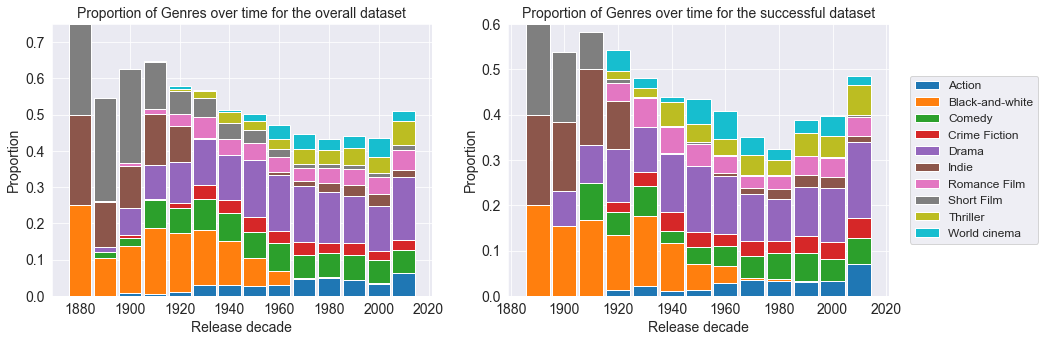

In [31]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plot_proportion('Genres')

plt.subplot(1, 2, 2)
plot_proportion('Genres', successful=True)

plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=12)
plt.show()
# plt.savefig('best_weightedRating_' + var_name + '_proportion_over_time.png', bbox_inches='tight')

From these two plots, we see almost no difference between the distribution of genres in the original dataset compared to the dataset containing only the succesful movies. This might be due to the fact that when a movie is successful, movies that are released not long after may try to take inspiration from it, for example its genre, its plot, etc... Thus, movies released in the same period of time might be similar, whether they become successful or not.

### g) Comparison between the evolution over time of the language distribution computed on the overall data and the one computed on successful movies only <a class="anchor" id="section_4_7"></a>

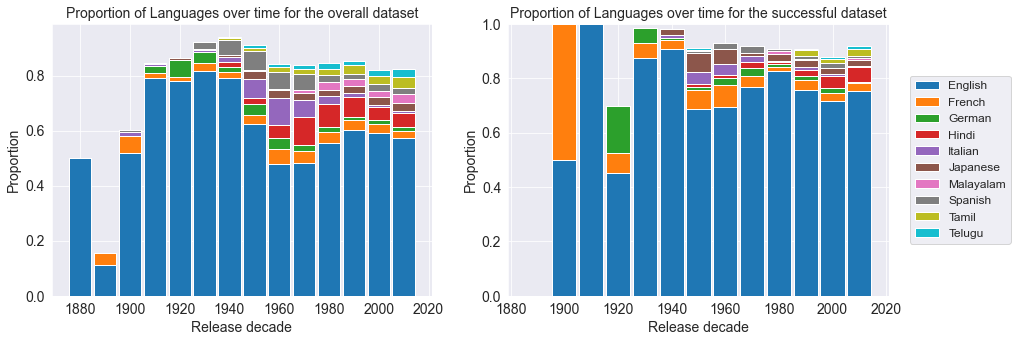

In [32]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plot_proportion('Languages')

plt.subplot(1, 2, 2)
plot_proportion('Languages', successful=True)

plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=12)
plt.show()
# plt.savefig('best_weightedRating_' + var_name + '_proportion_over_time.png', bbox_inches='tight')

English seems to be a factor of success.

## 5. Spatial analysis <a class="anchor" id="chapter5"></a>

### a) Proportion of successful movies per country <a class="anchor" id="section_5_1"></a>

In [33]:
df_reduced = create_reduced_df(['Countries', 'Weighted Rating'])

In [34]:
df_reduced = categorical_var_preprocessing(df_reduced, ['Countries'])
df_reduced

,Countries,Weighted Rating
0,United States of America,5.314323
1,United States of America,6.228941
2,Norway,6.228963
3,United Kingdom,6.217462
4,Germany,6.224511
...,...,...
64862,Russia,6.213104
64863,United States of America,6.128558
64864,United Kingdom,6.292316
64865,United States of America,6.228080


In [35]:
'''Compute the proportion of successful movies per country'''

df_groupby_country = df_reduced.groupby('Countries')

# Create a dictionary associating the proportion of successful movies to the name of the country
dict_movie_freq_per_country = {}
for group_name, df_group in df_groupby_country:
    dict_movie_freq_per_country[group_name] = len(df_group[df_group['Weighted Rating']>threshold]) / len(df_group)
    
# Compute the maximum proportion of successful movies that a country has
dict_values = dict_movie_freq_per_country.values()
max_value = max(dict_values)
print(f'The country with the maximum proportion of successful movies has {max_value*100:.3}% successful movies.')

The country with the maximum proportion of successful movies has 33.3% successful movies.


In [36]:
'''Load the data to create the world map'''

# Path to the shp file
shp_path = './World_Countries_(Generalized)/World_Countries__Generalized_.shp'

# Read the shape file
sf = shp.Reader(shp_path)

In [37]:
def plot_contour(arg_list, arg_alpha=0):
    df_coordinates = pd.DataFrame(arg_list, columns = ['Longitude', 'Latitude'])
    
    # Plot the country borders
    plt.plot(df_coordinates['Longitude'], df_coordinates['Latitude'], color='black')
    
    # Fill the borders with a gradient depending on the proportion of successful movies in this country
    plt.fill(df_coordinates['Longitude'], df_coordinates['Latitude'], color='red', alpha=arg_alpha)

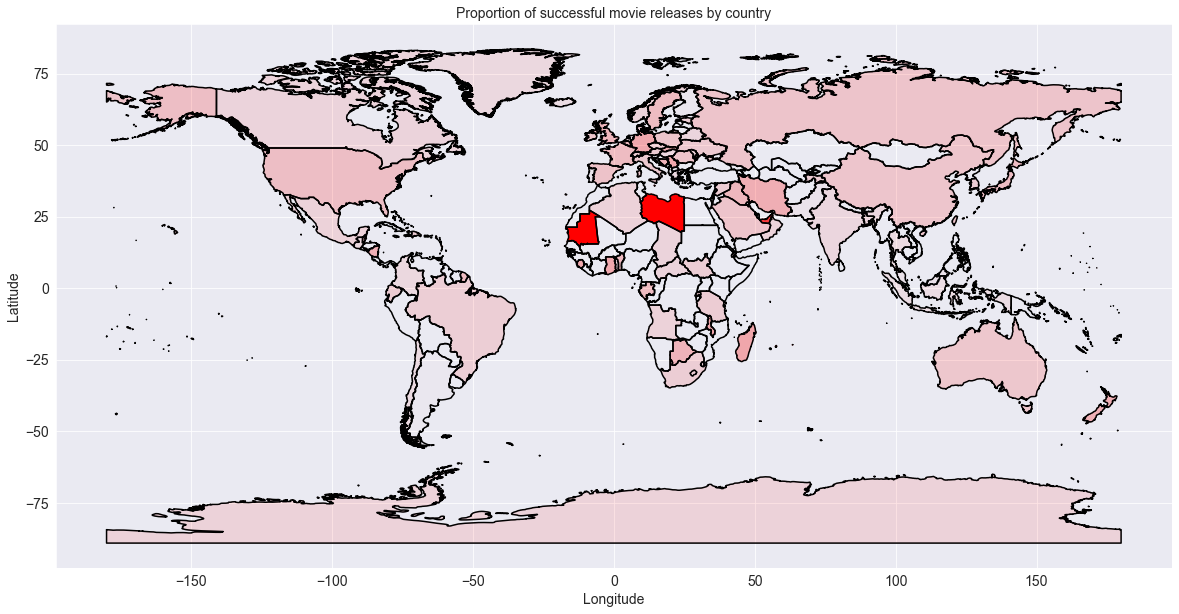

In [38]:
plt.figure(figsize=(20,10))

# Loop over all countries
for i in np.arange(0, len(sf.shapeRecords())):
    interface = sf.shapeRecords()[i].__geo_interface__
    
    # Country name
    country_name = interface['properties']['COUNTRY']
    
    # Gradient depending on the proportion of successful movies in this country
    matching = [elem for elem in list(dict_movie_freq_per_country.keys()) if country_name in elem]
    if len(matching)>=1:
        freq = dict_movie_freq_per_country[matching[0]]
        alpha = freq / max_value#math.log(1 + freq) / math.log(1 + max_value)
    
    # Border coordinates
    list_coordinates = interface['geometry']['coordinates']
    
    # Plot
    if len(list_coordinates) == 1:
        plot_contour(list_coordinates[0], arg_alpha=alpha)
    else:
        for j in np.arange(0, len(list_coordinates)):
            if type(list_coordinates[j][0]) == list:
                plot_contour(list_coordinates[j][0], arg_alpha=alpha)
            else:
                plot_contour(list_coordinates[j], arg_alpha=alpha)
                
plt.xticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)

plt.yticks(fontsize=14)
plt.ylabel('Latitude', fontsize=14)

plt.title('Proportion of successful movie releases by country', fontsize=14)
plt.show()
# plt.savefig('distribution_movie_by_country.png', bbox_inches='tight')

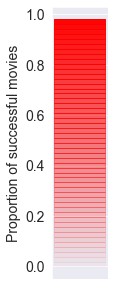

In [42]:
# Colorbar for the above plot, with color gradient depending on the proportion of successful movies in linear-scale
x = np.arange(10)

plt.figure(figsize=(1,5))
for i2 in range(1,51):
	i1 = (i2-1)/51
	i2 = i2/51

	y1 = i1*np.ones(10)
	y2 = i2*np.ones(10)
	plt.fill_between(x, y1, y2, color='red', alpha=i2)

plt.xticks([])

plt.yticks(fontsize=14)
plt.ylabel('Proportion of successful movies', fontsize=14)

plt.show()

From the world map above, Libia and Mauritania are the counties with the highest proportion of successful movies. But from the following world map that represents the number of movies released per countries, we can see that very few movies are released there. Thus, the high proportion of successful movies might be due to this country being more selective.

Among the other countries, the parts of the world wit high proportion of successful movies seem to be the ones with a lot of movie releases (eg. North America, Europe). This might come from the fact that movie industries where many movies are produced, are maybe better developed.

### b) Distribution of movie releases per country <a class="anchor" id="section_5_2"></a>

In [39]:
'''Compute the number of movies per country'''

list_countries = list(itertools.chain.from_iterable(df['Countries']))
dict_movie_freq_per_country = Counter(list_countries)

# Compute the maximum proportion of successful movies that a country has
dict_values = dict_movie_freq_per_country.values()
max_value = max(dict_values)
max_value

27318

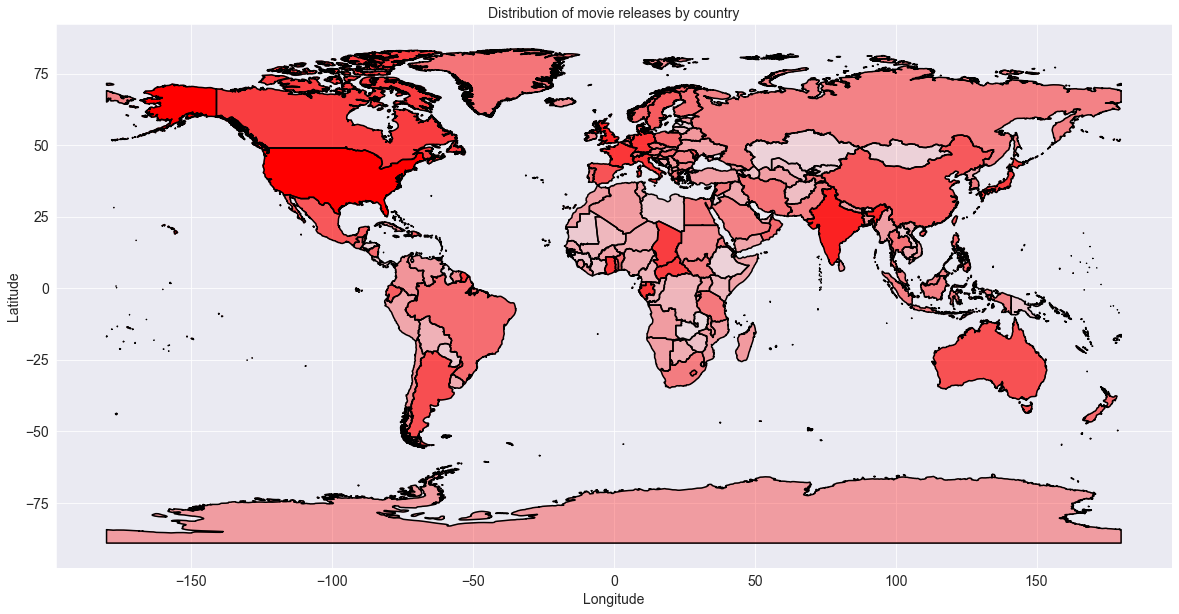

In [40]:
plt.figure(figsize=(20,10))

# Loop over all countries
for i in np.arange(0, len(sf.shapeRecords())):
    interface = sf.shapeRecords()[i].__geo_interface__
    
    # Country name
    country_name = interface['properties']['COUNTRY']
    
    # Gradient depending on the number of successful movies in this country
    matching = [elem for elem in list(dict_movie_freq_per_country.keys()) if country_name in elem]
    if len(matching)>=1:
        freq = dict_movie_freq_per_country[matching[0]]
        alpha = math.log(1 + freq) / math.log(1 + max_value) # log-scale
    
    # Border coordinates
    list_coordinates = interface['geometry']['coordinates']
    
    # Plot
    if len(list_coordinates) == 1:
        plot_contour(list_coordinates[0], arg_alpha=alpha)
    else:
        for j in np.arange(0, len(list_coordinates)):
            if type(list_coordinates[j][0]) == list:
                plot_contour(list_coordinates[j][0], arg_alpha=alpha)
            else:
                plot_contour(list_coordinates[j], arg_alpha=alpha)
                
plt.xticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)

plt.yticks(fontsize=14)
plt.ylabel('Latitude', fontsize=14)

plt.title('Distribution of movie releases by country', fontsize=14)
plt.show()
# plt.savefig('distribution_movie_by_country.png', bbox_inches='tight')

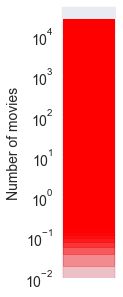

In [49]:
# Colorbar for the above plot, with color gradient depending on the number of movies in log-scale
x = np.arange(10)

plt.figure(figsize=(1,5))
for i2 in range(1,51):
	i1 = (i2-1)/51
	i2 = math.log(1 + i2) / math.log(1 + 51)

	y1 = i1*np.ones(10)
	y2 = i2*np.ones(10) * max_value
	plt.fill_between(x, y1, y2, color='red', alpha=i2)

plt.xticks([])

plt.yticks(fontsize=14)
plt.ylabel('Number of movies', fontsize=14)
plt.yscale('log')

plt.show()